In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline

In [2]:
#load data
file='C:/Users/pabma/ClimateTweetSentiment/Sample_Data/Processed/processed.csv'
df=pd.read_csv(file)

In [3]:
df.columns

Index(['sentiment', 'message', 'tweetid', 'datetime', 'date', 'year', 'month',
       'day', 'year_month', 'dayofweek', 'message_length', 'tokens',
       'word_count', 'average_tfidf'],
      dtype='object')

In [4]:
# incorporate features related to tweet content

import pandas as pd
import re
import emoji
from datetime import datetime

# function to determine if date is a weekend
def is_weekend(date):
    # Convert the string date to a datetime object
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    # Check if the day is Saturday (5) or Sunday (6)
    return 1 if date_obj.weekday() >= 5 else 0

# Function to identify if a message is a retweet
def is_retweet(message):
    return 1 if message.startswith('RT') else 0

# Function to extract user mentions
def extract_mentions(message):
    return re.findall(r'@\w+', message)

# Function to identify if a hashtag is present
def extract_hashtags(message):
    return re.findall(r'#\w+', message)

# Function to identify if a link is present
def has_link(message):
    return re.findall(r'http[s]?://', message)

# Function to identify if emojis are present and count them
def extract_emojis(message):
    return [char for char in message if emoji.is_emoji(char)]

# Apply the functions to create new columns
df['is_weekend'] = df['date'].apply(is_weekend)
df['is_retweet'] = df['message'].apply(is_retweet)

df['mentions'] = df['message'].apply(extract_mentions)
df['hashtags'] = df['message'].apply(extract_hashtags)
df['links'] = df['message'].apply(has_link)
df['emojis'] = df['message'].apply(extract_emojis)

# Count the number of mentions, hashtags, links, and emojis
df['num_mentions'] = df['mentions'].apply(len)
df['num_hashtags'] = df['hashtags'].apply(len)
df['num_links'] = df['links'].apply(len)
df['num_emojis'] = df['emojis'].apply(len)

In [5]:
df.head()

,sentiment,message,tweetid,datetime,date,year,month,day,year_month,dayofweek,...,is_weekend,is_retweet,mentions,hashtags,links,emojis,num_mentions,num_hashtags,num_links,num_emojis
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,2016-10-30 23:13:07.701,2016-10-30,2016,10,30,2016-10,SUN,...,1,0,[@tiniebeany],[],[],[],1,0,0,0
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,2016-10-31 12:15:22.218,2016-10-31,2016,10,31,2016-10,MON,...,0,1,"[@NatGeoChannel, @LeoDiCaprio]",[#BeforeTheFlood],[https://],[],2,1,1,0
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,2016-10-31 12:16:07.725,2016-10-31,2016,10,31,2016-10,MON,...,0,0,[@youtube],"[#DiCaprio, #climate]",[https://],[],1,2,1,0
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,2016-10-31 12:17:03.392,2016-10-31,2016,10,31,2016-10,MON,...,0,1,[@Mick_Fanning],[],[https://],[],1,0,1,0
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,2016-10-31 12:19:07.444,2016-10-31,2016,10,31,2016-10,MON,...,0,1,[@cnalive],[],[],[],1,0,0,0


In [8]:
## word preprocessing, over full dataset

# Define additional stop words

additional_stop_words = ['rt', 'climate', 'change','global', 'warming','trump']

# preprocess
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Get the existing stop words from nltk
stop_words = set(stopwords.words('english'))

# Add custom stop words to the set
stop_words.update(additional_stop_words)

# preprocessing function
def preprocess_text(message):
    # Lowercase the text
    message = message.lower()
    # Remove punctuation
    message = re.sub(r'[^\w\s]', '', message)
    # Tokenize and remove stopwords
    tokens = message.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# apply preprocessing
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the tweets
df['processed_message'] = df['message'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pabma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Split the data into train and test sets by time
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

print('train:',len(train_df), 'test:',len(test_df))

train: 35154 test: 8789


In [10]:
# LDA over train set

num_topics = 4 # number of topics to find
max_features = 5000 # max features parameter

# Create a document-term matrix
count_vectorizer = CountVectorizer(max_features=max_features)
dtm = count_vectorizer.fit_transform(train_df['processed_message'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get topic distribution for each tweet
topic_distributions = lda.transform(dtm)

# Add topic distributions to the dataframe to the train set
for i in range(num_topics):
    train_df[f'topic_{i}'] = topic_distributions[:, i]

# Add the most likely topic column
train_df['most_likely_topic'] = np.argmax(topic_distributions, axis=1)


C:\Users\pabma\AppData\Local\Temp\ipykernel_25696\3202783451.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'topic_{i}'] = topic_distributions[:, i]
C:\Users\pabma\AppData\Local\Temp\ipykernel_25696\3202783451.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'topic_{i}'] = topic_distributions[:, i]
C:\Users\pabma\AppData\Local\Temp\ipykernel_25696\3202783451.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

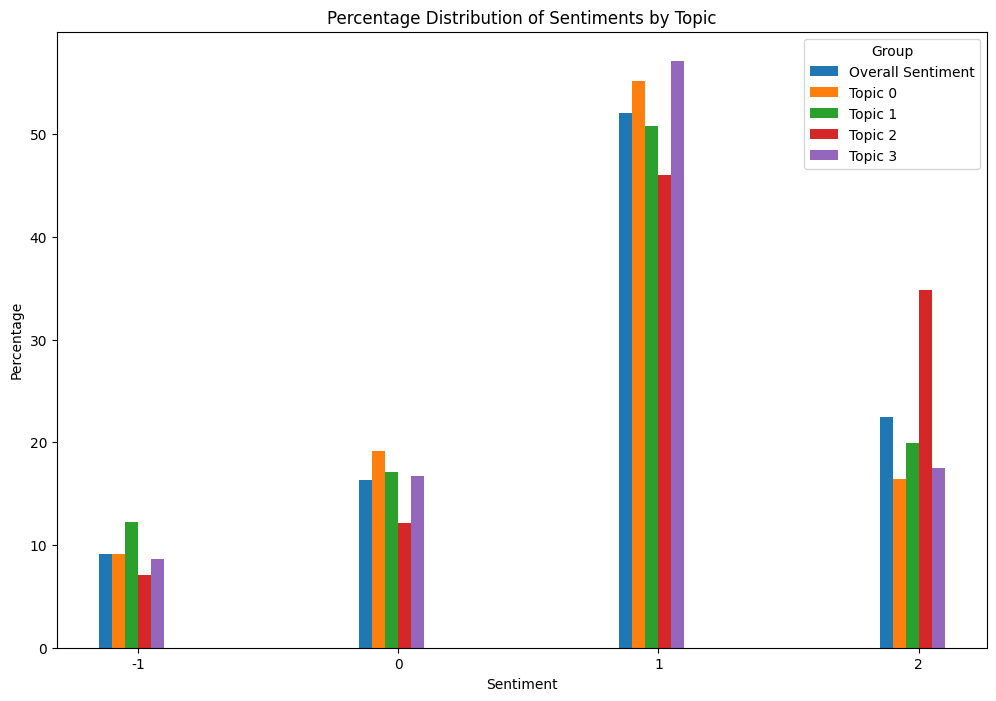

In [11]:
import matplotlib.pyplot as plt

# Calculate percentage distribution of sentiment values for each topic
topic_sentiment_counts = train_df.groupby(['most_likely_topic', 'sentiment']).size().unstack(fill_value=0)
topic_sentiment_percentage = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0) * 100

# Calculate overall sentiment distribution
overall_sentiment_counts = train_df['sentiment'].value_counts(normalize=True) * 100

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.05  # Width of the bars

# Plot the overall sentiment distribution
overall_positions = np.arange(len(overall_sentiment_counts))
ax.bar(overall_positions, overall_sentiment_counts.sort_index(), width=width, label='Overall Sentiment')

# Plot the percentage distribution for each topic
for i in range(num_topics):
    positions = overall_positions + (i + 1) * width
    ax.bar(positions, topic_sentiment_percentage.loc[i].sort_index(), width=width, label=f'Topic {i}')

# Set the x-ticks to be in the center of the groups of bars
ax.set_xticks(overall_positions + width * (num_topics + 1) / 2)
ax.set_xticklabels(overall_sentiment_counts.sort_index().index)

ax.set_title('Percentage Distribution of Sentiments by Topic')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.legend(title='Group')
plt.show()


In [12]:
# Apply to test data set
dtm_test = count_vectorizer.transform(test_df['processed_message'])
topic_distributions_test = lda.transform(dtm_test)
for i in range(num_topics):
    test_df[f'topic_{i}'] = topic_distributions_test[:, i]

# Add the most likely topic column
test_df['most_likely_topic'] = np.argmax(topic_distributions_test, axis=1)


C:\Users\pabma\AppData\Local\Temp\ipykernel_25696\3776286683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'topic_{i}'] = topic_distributions_test[:, i]
C:\Users\pabma\AppData\Local\Temp\ipykernel_25696\3776286683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'topic_{i}'] = topic_distributions_test[:, i]
C:\Users\pabma\AppData\Local\Temp\ipykernel_25696\3776286683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Topic 0:


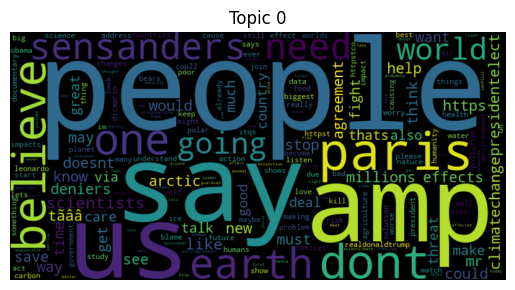

Topic 0:


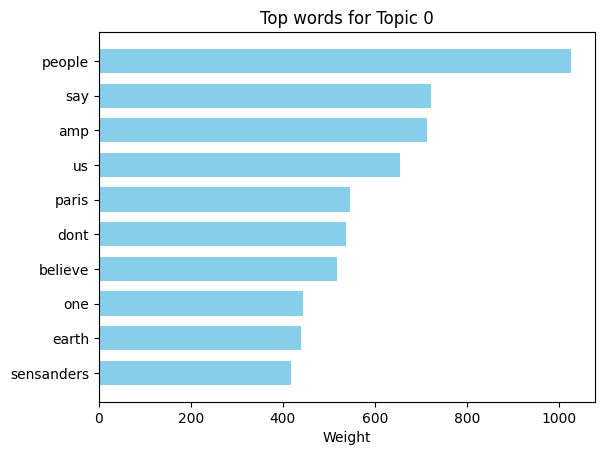

Topic 1:


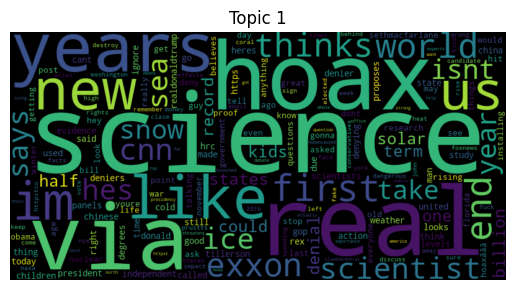

Topic 1:


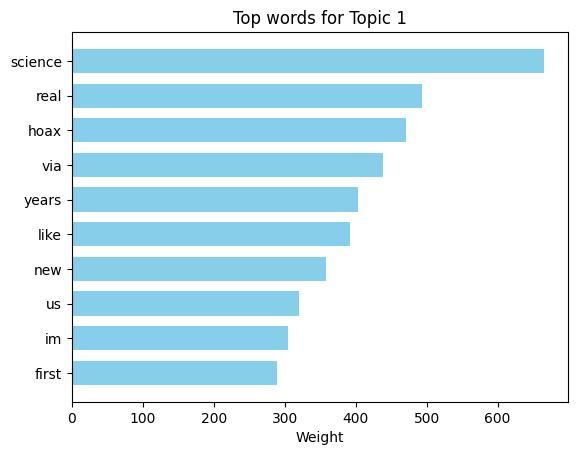

Topic 2:


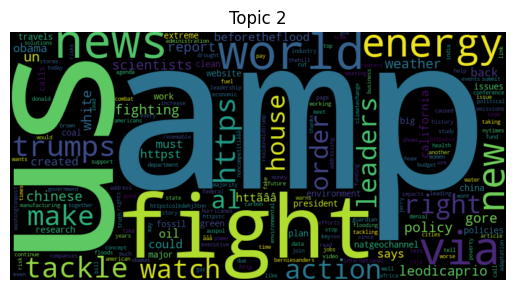

Topic 2:


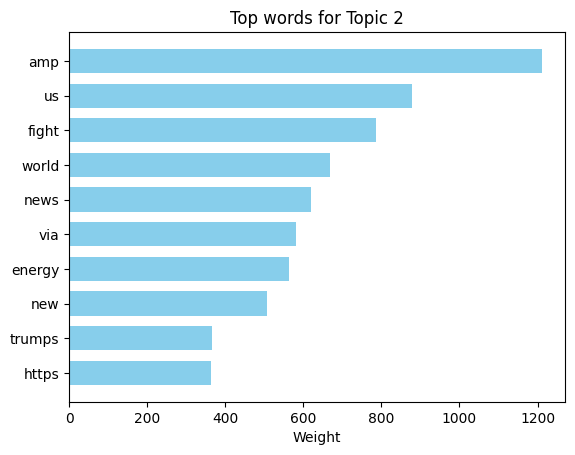

Topic 3:


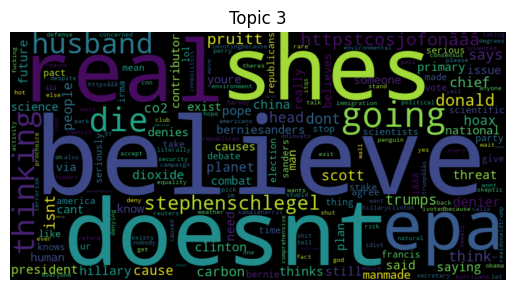

Topic 3:


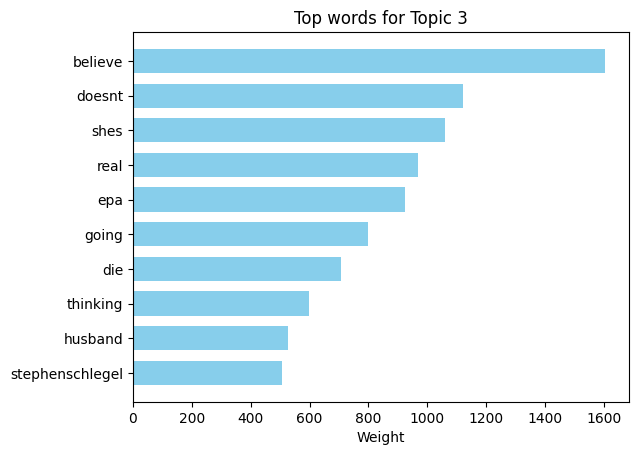

In [13]:
#visualize the topics in wordcloud
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

# Get the feature names (words)
feature_names = count_vectorizer.get_feature_names_out()
top_n = 10 # top words by frequency to show


# Create a word cloud for each topic
for topic_idx, topic in enumerate(lda.components_):

    # wordcloud
    print(f"Topic {topic_idx}:")
    wordcloud = WordCloud(width=800, height=400).fit_words(dict(zip(feature_names, topic)))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx}")
    plt.show()

    # barcharts
    print(f"Topic {topic_idx}:")
    top_features_ind = topic.argsort()[: -top_n - 1: -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    plt.figure()
    plt.barh(top_features, weights, height=0.7, color='skyblue')
    plt.xlabel('Weight')
    plt.title(f'Top words for Topic {topic_idx}')
    plt.gca().invert_yaxis()
    plt.show()


In [14]:
train_df.head()

,sentiment,message,tweetid,datetime,date,year,month,day,year_month,dayofweek,...,num_mentions,num_hashtags,num_links,num_emojis,processed_message,topic_0,topic_1,topic_2,topic_3,most_likely_topic
36742,1,We need our leaders to speak out on climate ch...,592633384804966400,2015-04-27 06:16:24.190,2015-04-27,2015,4,27,2015-04,MON,...,0,0,1,0,need leaders speak stay silent guardian httptc...,0.530290,0.213619,0.219675,0.036416,0
36743,1,RT @WhiteHouse: RT if you agree: It$q$s time t...,592668667273416704,2015-04-27 08:36:36.186,2015-04-27,2015,4,27,2015-04,MON,...,1,1,1,0,whitehouse agree itqs time mobilize world comb...,0.900529,0.031866,0.032615,0.034989,0
36744,2,Koch think tank says the Pope is wrong about c...,592703015309705216,2015-04-27 10:53:05.396,2015-04-27,2015,4,27,2015-04,MON,...,0,0,1,0,koch think tank says pope wrong httptcojzldypurqo,0.389468,0.037511,0.036298,0.536723,3
36745,-1,RT @JunkScience: WaPo: Close Mt. Everest b/c o...,592860482358345728,2015-04-27 21:18:48.466,2015-04-27,2015,4,27,2015-04,MON,...,1,0,1,0,junkscience wapo close mt everest bc httptcobp...,0.847298,0.051693,0.050173,0.050836,0
36746,2,Obamas Earth Day trek to Fla. to highlight cli...,592878900671307777,2015-04-27 22:31:59.734,2015-04-27,2015,4,27,2015-04,MON,...,0,0,0,0,obamas earth day trek fla highlight,0.624916,0.055028,0.267275,0.052781,0


In [15]:
train_df.columns

Index(['sentiment', 'message', 'tweetid', 'datetime', 'date', 'year', 'month',
       'day', 'year_month', 'dayofweek', 'message_length', 'tokens',
       'word_count', 'average_tfidf', 'is_weekend', 'is_retweet', 'mentions',
       'hashtags', 'links', 'emojis', 'num_mentions', 'num_hashtags',
       'num_links', 'num_emojis', 'processed_message', 'topic_0', 'topic_1',
       'topic_2', 'topic_3', 'most_likely_topic'],
      dtype='object')

In [17]:
# Train models
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

feature_set=['is_weekend',  #date info
            'message_length','word_count', # length info
            'is_retweet', 'num_mentions','num_hashtags','num_links','num_emojis', #character infp
            'topic_0','topic_1', 'topic_2', 'topic_3'] #topics info

# Define the features and target
X_train = train_df[feature_set]
y_train = train_df['sentiment']
feature_names = X_train.columns

# Logistic Regression with Regularization
logistic_classifier = LogisticRegression(max_iter=1000, multi_class='multinomial', C=0.1)
logistic_classifier.fit(X_train, y_train)

# Decision Tree with Pruning
dt_classifier = DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10)
dt_classifier.fit(X_train, y_train)

# Random Forest with Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [20, 50],
    'min_samples_leaf': [10, 20]
}
rf_classifier = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_classifier = grid_search.best_estimator_

c:\Users\pabma\ClimateTweetSentiment\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\pabma\ClimateTweetSentiment\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [18]:
# TRAIN SET METRICS
from sklearn.metrics import classification_report, accuracy_score

# Predict on the train set
logistic_predictions_train = logistic_classifier.predict(X_train)
dt_predictions_train = dt_classifier.predict(X_train)
rf_predictions_train = best_rf_classifier.predict(X_train)

# Calculate classification metrics
logistic_report_train = classification_report(y_train, logistic_predictions_train, output_dict=True)
dt_report_train = classification_report(y_train, dt_predictions_train, output_dict=True)
rf_report_train = classification_report(y_train, rf_predictions_train, output_dict=True)

# Print classification reports
print("Logistic Regression Classification Report (Train Set)")
print(classification_report(y_train, logistic_predictions_train))

print("Decision Tree Classification Report (Train Set)")
print(classification_report(y_train, dt_predictions_train))

print("Random Forest Classification Report (Train Set)")
print(classification_report(y_train, rf_predictions_train))

# Print accuracy scores
logistic_accuracy_train = accuracy_score(y_train, logistic_predictions_train)
dt_accuracy_train = accuracy_score(y_train, dt_predictions_train)
rf_accuracy_train = accuracy_score(y_train, rf_predictions_train)

print("Logistic Regression Accuracy (Train Set):", logistic_accuracy_train)
print("Decision Tree Accuracy (Train Set):", dt_accuracy_train)
print("Random Forest Accuracy (Train Set):", rf_accuracy_train)


Logistic Regression Classification Report (Train Set)
              precision    recall  f1-score   support

          -1       0.27      0.00      0.00      3216
           0       0.55      0.19      0.28      5733
           1       0.60      0.86      0.71     18297
           2       0.58      0.51      0.54      7908

    accuracy                           0.59     35154
   macro avg       0.50      0.39      0.38     35154
weighted avg       0.56      0.59      0.54     35154

Decision Tree Classification Report (Train Set)
              precision    recall  f1-score   support

          -1       0.56      0.09      0.15      3216
           0       0.59      0.33      0.42      5733
           1       0.64      0.85      0.73     18297
           2       0.64      0.60      0.62      7908

    accuracy                           0.64     35154
   macro avg       0.61      0.47      0.48     35154
weighted avg       0.63      0.64      0.60     35154

Random Forest Classification

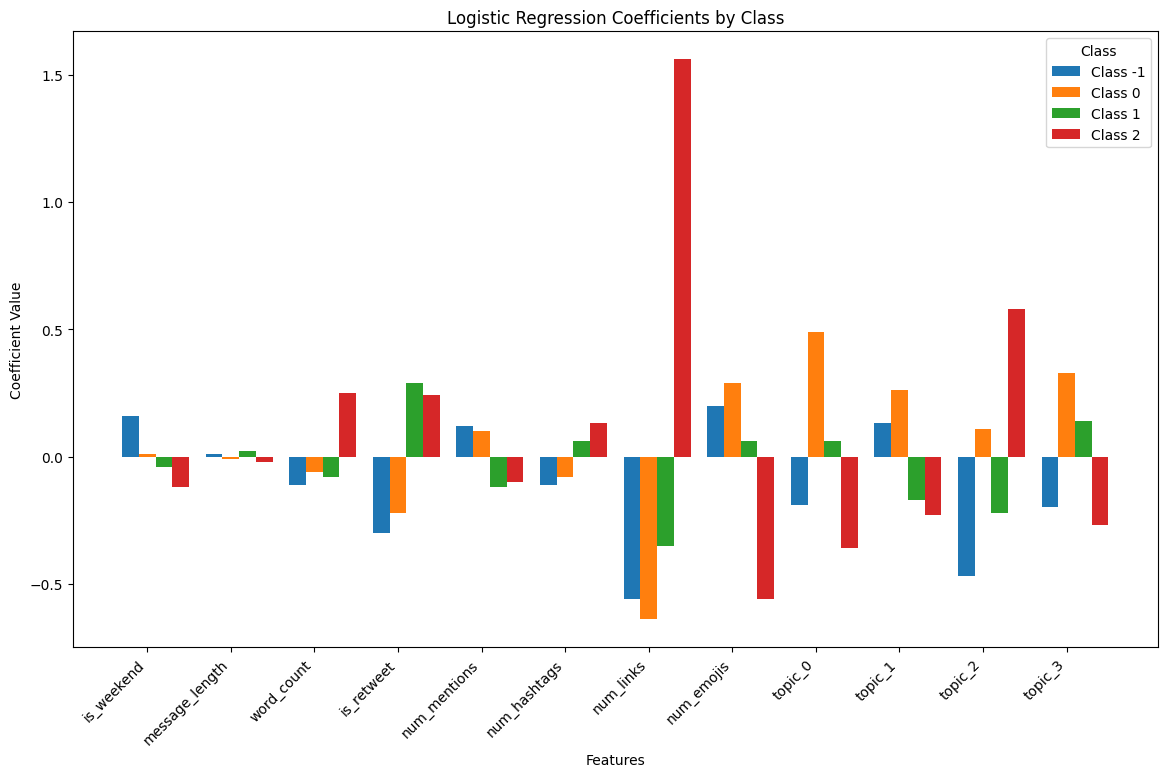

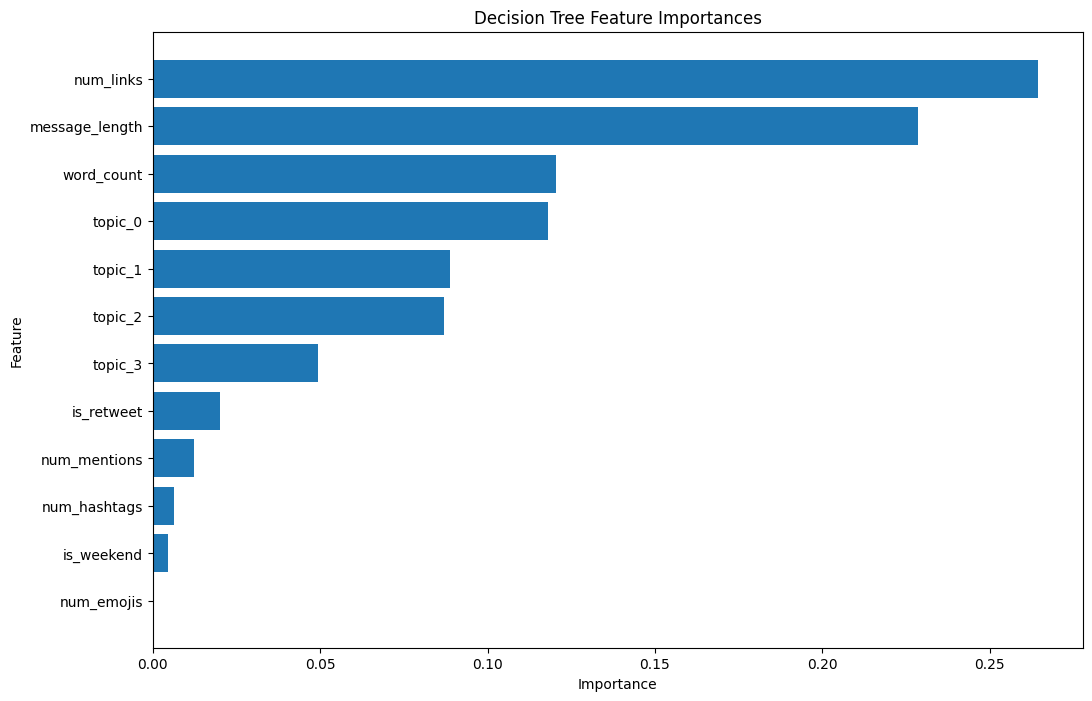

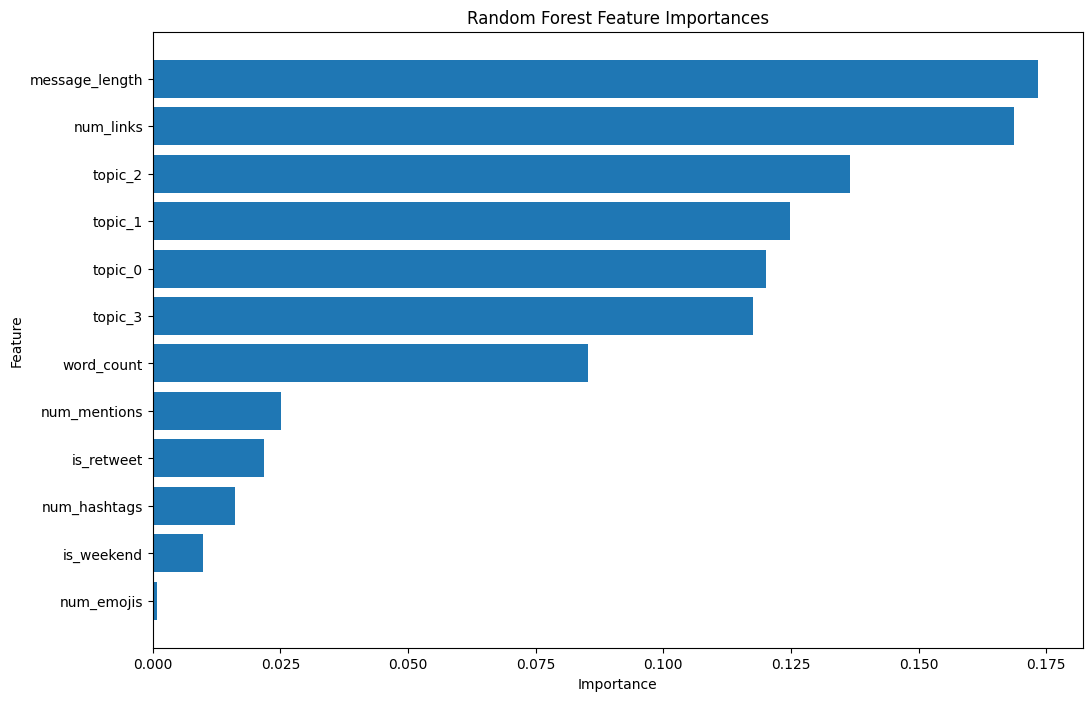

In [19]:
# Visualize feature importance

# Logistic Regression Coefficients
logistic_coefficients = logistic_classifier.coef_
logistic_coef_df = pd.DataFrame(logistic_coefficients, columns=feature_names)
logistic_coef_df.index = [f'Class {label}' for label in logistic_classifier.classes_]
logistic_coef_df = logistic_coef_df.round(2)

# Plot Logistic Regression Coefficients side by side
plt.figure(figsize=(14, 8))
bar_width = 0.2
index = np.arange(len(feature_names))

for i, (idx, row) in enumerate(logistic_coef_df.iterrows()):
    plt.bar(index + i * bar_width, row, bar_width, label=idx)

plt.title('Logistic Regression Coefficients by Class')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(index + bar_width, feature_names, rotation=45, ha='right')
plt.legend(title='Class')
plt.show()

# Decision Tree Feature Importances
dt_feature_importances = dt_classifier.feature_importances_
dt_feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Decision Tree Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(dt_feature_importances_df['Feature'], dt_feature_importances_df['Importance'])
plt.title('Decision Tree Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Random Forest Feature Importances
rf_feature_importances = best_rf_classifier.feature_importances_
rf_feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Random Forest Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(rf_feature_importances_df['Feature'], rf_feature_importances_df['Importance'])
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()

plt.show()

In [20]:
## TEST SET PERFORMANCE
from sklearn.metrics import classification_report, accuracy_score

X_test = test_df[feature_set]
y_test = test_df['sentiment']

# Predict on the test set
logistic_predictions = logistic_classifier.predict(X_test)
dt_predictions = dt_classifier.predict(X_test)
rf_predictions = best_rf_classifier.predict(X_test)

# Calculate classification metrics
logistic_report = classification_report(y_test, logistic_predictions, output_dict=True)
dt_report = classification_report(y_test, dt_predictions, output_dict=True)
rf_report = classification_report(y_test, rf_predictions, output_dict=True)

# Print classification reports
print("Logistic Regression Classification Report")
print(classification_report(y_test, logistic_predictions))

print("Decision Tree Classification Report")
print(classification_report(y_test, dt_predictions))

print("Random Forest Classification Report")
print(classification_report(y_test, rf_predictions))

# Print accuracy scores
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
dt_accuracy = accuracy_score(y_test, dt_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print("Logistic Regression Accuracy:", logistic_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

Logistic Regression Classification Report
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       774
           0       0.60      0.20      0.30      1982
           1       0.59      0.84      0.69      4665
           2       0.47      0.53      0.50      1368

    accuracy                           0.57      8789
   macro avg       0.42      0.39      0.37      8789
weighted avg       0.52      0.57      0.51      8789

Decision Tree Classification Report
              precision    recall  f1-score   support

          -1       0.19      0.02      0.04       774
           0       0.56      0.27      0.37      1982
           1       0.60      0.80      0.69      4665
           2       0.47      0.53      0.50      1368

    accuracy                           0.57      8789
   macro avg       0.46      0.41      0.40      8789
weighted avg       0.54      0.57      0.53      8789

Random Forest Classification Report
              pr

In [21]:
#Output Predictions using the trained models for full dataset

combined_df = pd.concat([train_df, test_df], ignore_index=True)
X_combined = combined_df[feature_set]
y_combined = combined_df['sentiment']

# Transform the combined dataset using the count_vectorizer
dtm_combined = count_vectorizer.transform(combined_df['processed_message'])

# Get topic distribution for each tweet in the combined dataset using the LDA model
topic_distributions_combined = lda.transform(dtm_combined)

# Add topic distributions to the combined dataframe
for i in range(num_topics):
    combined_df[f'topic_{i}'] = topic_distributions_combined[:, i]

# Update the feature set with the new topic columns
X_combined = combined_df[feature_set]

# Predictions using the trained models
logistic_predictions_combined = logistic_classifier.predict(X_combined)
dt_predictions_combined = dt_classifier.predict(X_combined)
rf_predictions_combined = best_rf_classifier.predict(X_combined)

# Add predictions to the combined dataframe
combined_df['logistic_prediction'] = logistic_predictions_combined
combined_df['dt_prediction'] = dt_predictions_combined
combined_df['rf_prediction'] = rf_predictions_combined

# Export the combined dataframe with predictions to a CSV file
combined_df.to_csv('predictions_combined.csv', index=False)

print("Predictions exported to 'predictions_combined.csv'")

Predictions exported to 'predictions_combined.csv'
